In [36]:
import pandas as pd
import numpy as np
from os import path
import seaborn as sns
import matplotlib.pyplot as plt
import os
import wntr
import networkx as nx
from matplotlib import rcParams
from sklearn.preprocessing import MinMaxScaler

# Reliability to resilience

Reads the output from procedure_stresstesting.py

In [4]:
aspects = ['Service', 'Spatial']
dimensions = ['Magnitude', 'Peak', 'Time to Peak', 'Time to Recovery']
path_result = 'results/reliability'
files = [filename for filename in os.listdir(path_result)]


In [8]:
def get_reliability(df, aspect, dimension, threshold):
    return df[(df['Aspect'] == aspect) & (df['Dimension'] == dimension) & (df['Threshold'] == threshold)]

df1 = pd.read_csv(os.path.join(path_result, files[0]), index_col=0)
s1 = get_reliability(df1, aspects[1], dimensions[0], 1)
print(files[0])
print(s1)

Ctown_100_reliability.csv
       Simulation  Dimension   Aspect  Threshold  Reliability      Stress
10              1  Magnitude  Spatial          1    56.958763    1.030928
28              1  Magnitude  Spatial          1    78.350515    1.804124
46              1  Magnitude  Spatial          1    65.979381    3.092784
64              1  Magnitude  Spatial          1    24.742268    5.154639
82              1  Magnitude  Spatial          1    22.938144    8.762887
...           ...        ...      ...        ...          ...         ...
35938         200  Magnitude  Spatial          1     4.639175   23.195876
35956         200  Magnitude  Spatial          1     2.835052   37.628866
35974         200  Magnitude  Spatial          1     2.061856   61.340206
35992         200  Magnitude  Spatial          1     1.546392  100.000000
36010           0  Magnitude  Spatial          1   100.000000    0.000000

[2001 rows x 6 columns]


In [9]:
data = list()
aspects = ['Service', 'Spatial']
dimensions = ['Magnitude', 'Peak']
for filename in files[:10]:
    df = pd.read_csv(os.path.join(path_result, filename), index_col=0)
    fname = filename.split('_')
    df['Network'] = f'{fname[0]}_{fname[1]}'
    data.append(df)

df = pd.concat(data)
df = df[(df['Threshold']) == 1]
df = df[df['Aspect'].isin(aspects) & df['Dimension'].isin(dimensions)]


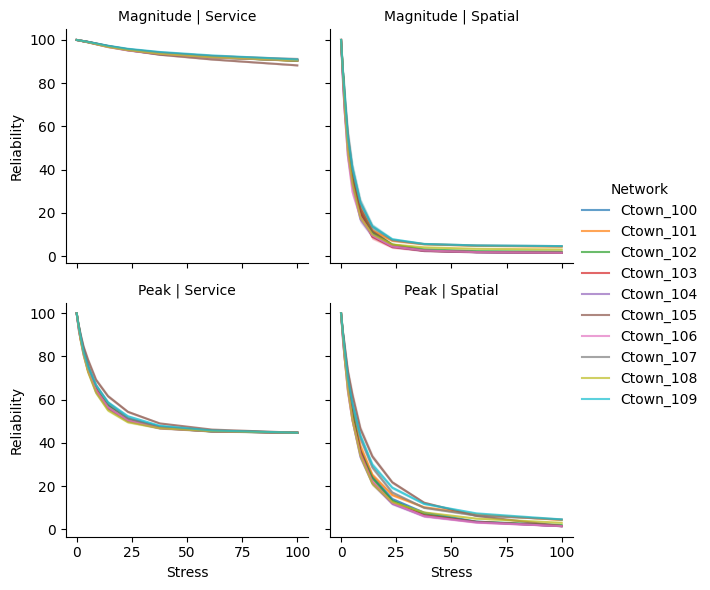

In [10]:
g = sns.FacetGrid(df, col="Aspect", row="Dimension", hue="Network")
g.map(sns.lineplot, "Stress", "Reliability", alpha=.7)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend()

plt.show()

In [99]:
aspects = ['Service', 'Spatial']
dimensions = ['Magnitude', 'Peak']
threshold = 1
data = []
for filename in files:
    fname = filename.split('_')
    network = f'variant_{fname[1]}'
    df = pd.read_csv(os.path.join(path_result, filename), index_col=0)
    tempdata = [network, None, None, None, None]
    for a in aspects:
        for d in dimensions:         
            temp = get_reliability(df, a, d, threshold)
            if d == 'Magnitude' and a == 'Service':
                tempdata[1] = temp['Reliability'].mean()
            elif d == 'Peak' and a == 'Service':
                tempdata[2] = temp['Reliability'].mean()
            elif d == 'Magnitude' and a == 'Spatial':
                tempdata[3] = temp['Reliability'].mean()
            else:
                tempdata[4] = temp['Reliability'].mean()
    data.append(tempdata)
    
data = pd.DataFrame(data, columns=['Network', 'S', 'Sp', 'N', 'Np'])
data = data.set_index('Network')
data.to_csv('results/resilience_result.csv')
print(data)

                     S         Sp          N         Np
Network                                                
variant_100  96.644354  65.021415  27.887345  37.902054
variant_101  96.566874  64.542678  29.952549  39.168174
variant_102  96.484038  64.961804  28.133614  37.425231
variant_103  96.661109  64.567980  27.104747  36.640056
variant_104  96.388156  64.140770  25.874692  35.622653
...                ...        ...        ...        ...
variant_96   95.796458  64.311538  25.249617  36.382968
variant_97   96.601278  64.866543  28.157571  37.340608
variant_98   96.541126  64.527648  27.584017  36.608371
variant_99   96.670679  65.362779  28.348197  39.233734
variant_9    96.854182  67.290898  30.910962  43.564043

[294 rows x 4 columns]


The resilience of the benchmark model.

In [353]:


df = pd.read_csv('Ctown_reliability.csv', index_col=0)
tempdata = ['benchmark', None, None, None, None]
n = 100
for a in aspects:
    for d in dimensions:         
        temp = get_reliability(df, a, d, threshold)
        if d == 'Magnitude' and a == 'Service':
            tempdata[1] = temp['Reliability'].sample(n).mean()
        elif d == 'Peak' and a == 'Service':
            tempdata[2] = temp['Reliability'].sample(n).mean()
        elif d == 'Magnitude' and a == 'Spatial':
            tempdata[3] = temp['Reliability'].sample(n).mean()
        else:
            tempdata[4] = temp['Reliability'].sample(n).mean()

print(tempdata)
ctown_resilience = tempdata.copy()

['benchmark', 95.52016399825516, 72.27005438040942, 33.38659793814433, 46.62371134020619]


In [350]:
df = pd.read_csv('Ctown_reliability.csv', index_col=0)
tempdata = ['benchmark', None, None, None, None]
n = 400
for a in aspects:
    for d in dimensions:         
        temp = get_reliability(df, a, d, threshold)
        if d == 'Magnitude' and a == 'Service':
            tempdata[1] = temp['Reliability'].sample(n).mean()
        elif d == 'Peak' and a == 'Service':
            tempdata[2] = temp['Reliability'].sample(n).mean()
        elif d == 'Magnitude' and a == 'Spatial':
            tempdata[3] = temp['Reliability'].sample(n).mean()
        else:
            tempdata[4] = temp['Reliability'].sample(n).mean()

print(tempdata)

df_normal = data.copy()
df_normal['Network'] = df_normal.index
df_normal.index = range(294)
df_normal = df_normal.append(dict(zip(['Network', 'S', 'Sp', 'N', 'Np'], tempdata)), ignore_index=True)
df_normal = df_normal.set_index('Network')
for col in ['S', 'Sp', 'N', 'Np']:
    df_normal[col] = MinMaxScaler().fit_transform(np.array(df_normal[col]).reshape(-1,1))

df_normal['Overall'] = MinMaxScaler().fit_transform(np.array(df_normal.sum(axis=1)).reshape(-1,1))
df_normal.to_csv('results/resilience_normal.csv')
print(df_normal)

['benchmark', 95.85286121140962, 68.28551117586903, 30.428479381443296, 47.0451030927835]
                    S        Sp         N        Np   Overall
Network                                                      
variant_100  0.755866  0.317418  0.433360  0.265179  0.420457
variant_101  0.710036  0.217305  0.679473  0.366937  0.494267
variant_102  0.661038  0.304952  0.462709  0.226857  0.377958
variant_103  0.765777  0.222596  0.340097  0.163753  0.318257
variant_104  0.604322  0.133259  0.193510  0.081985  0.143117
...               ...       ...       ...       ...       ...
variant_97   0.730387  0.285031  0.465564  0.220056  0.394583
variant_98   0.694806  0.214162  0.397213  0.161207  0.309178
variant_99   0.771438  0.388803  0.488281  0.372206  0.511438
variant_9    0.879982  0.792008  0.793688  0.720230  0.937340
benchmark    0.287690  1.000000  0.736190  1.000000  0.878114

[295 rows x 5 columns]


C:\Users\elir\AppData\Local\Temp\ipykernel_9884\750634170.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_normal = df_normal.append(dict(zip(['Network', 'S', 'Sp', 'N', 'Np'], tempdata)), ignore_index=True)


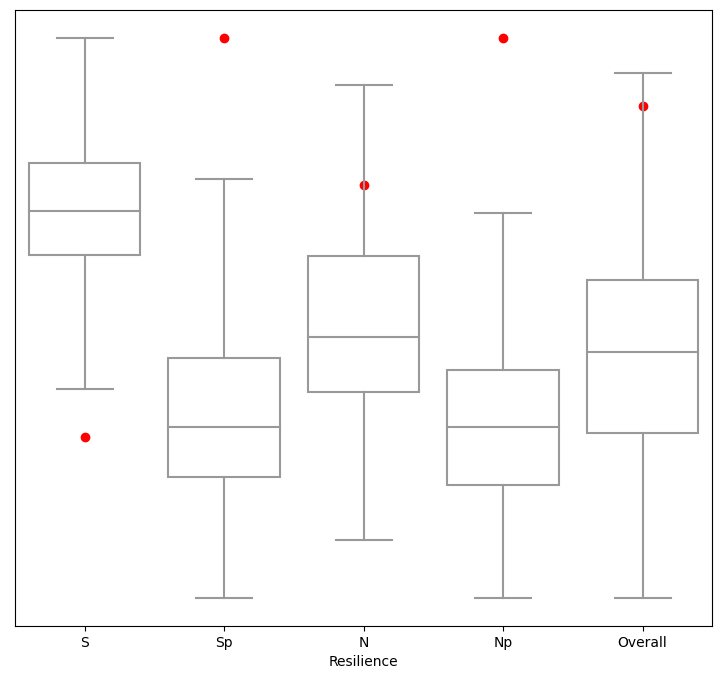

In [358]:
tempdata = list()
for col in df_normal.columns:
    temp = pd.DataFrame()
    temp['Value'] = df_normal[col].to_list()
    temp['Resilience'] = col
    temp['Network'] = attributes_normal.index
    temp['Benchmark model'] = 'False'
    temp.loc[temp['Network'] == 'benchmark', 'Benchmark model'] = 'True' 
    tempdata.append(temp)

tempdata = pd.concat(tempdata)

fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax = sns.boxplot(data=tempdata, x="Resilience", y="Value", color='white', showfliers = False)



for att, res in zip(['S', 'Sp', 'N', 'Np', 'Overall'], tempdata.loc[tempdata['Network'] == 'benchmark', 'Value'].to_list()):
    ax.scatter(att, res, alpha=1, color='red')
plt.yticks([])
plt.ylabel('')
plt.show()

# Calculate the topological attributes

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "Ctown.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_201.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))


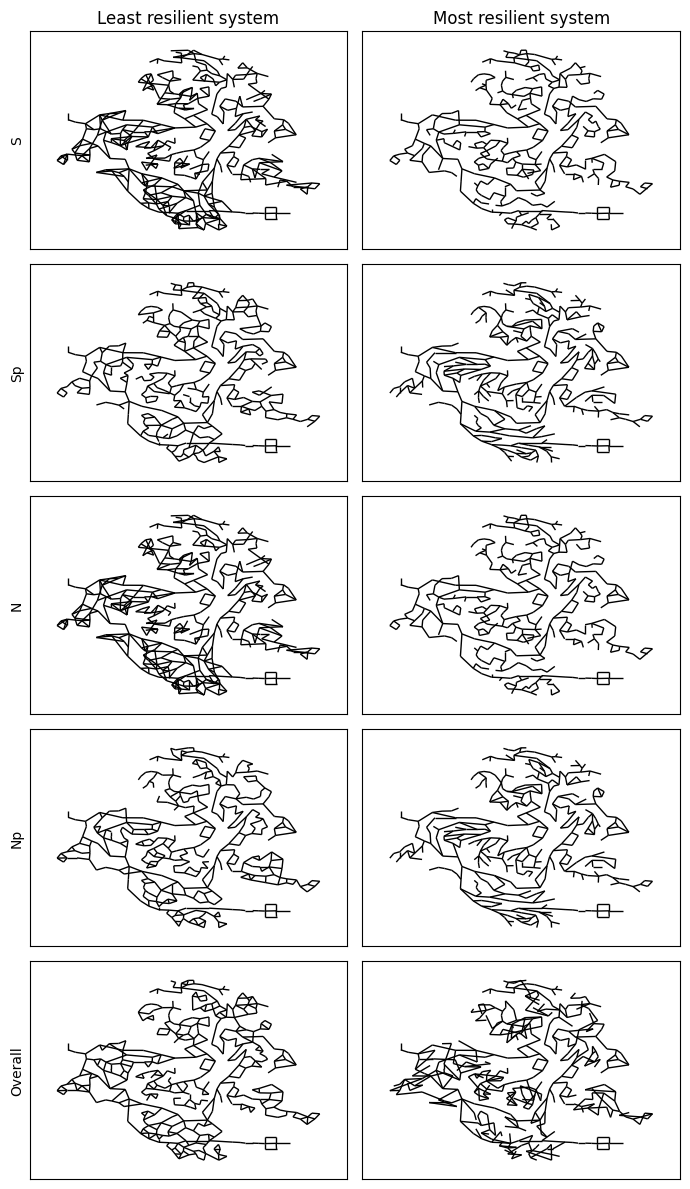

In [252]:
def get_graph(wn):
    graph = wntr.network.WaterNetworkModel.to_graph(wn).to_undirected()
    pos = dict()
    for name in wn.node_name_list:
            node = wn.get_node(name)
            pos[name] = node.coordinates
    return graph, pos

kpi = ['S', 'Sp', 'N', 'Np', 'Overall']
fig, ax = plt.subplots(5, 2, figsize=(7, 12))
n = 0
for i, kpi in enumerate(kpi):
    min_i = df_normal[kpi].sort_values(ascending=True).head(n+1).index.tolist()
    if min_i[n] == 'benchmark':
        wn = wntr.network.WaterNetworkModel(f'Ctown.inp')
    else:
        wn = wntr.network.WaterNetworkModel(f'variants/{min_i[n]}.inp')
    G, pos = get_graph(wn)
    nx.draw_networkx_edges(G, pos, ax=ax[i, 0])
    ax[i, 0].set_ylabel(kpi)
    max_i = df_normal[kpi].sort_values(ascending=False).head(n+1).index.tolist()
    
    if max_i[n] == 'benchmark':
        wn = wntr.network.WaterNetworkModel('Ctown.inp')
    else:
        wn = wntr.network.WaterNetworkModel(f'variants/{max_i[n]}.inp')
    G, pos = get_graph(wn)
    nx.draw_networkx_edges(G, pos, ax=ax[i, 1])

ax[0, 0].set_title('Least resilient system')
ax[0, 1].set_title('Most resilient system')

plt.tight_layout()
plt.show()

In [131]:
def topological_attributes(G):
    uG = G.to_undirected()
    sG = nx.Graph(uG)
    return [nx.density(G),
            nx.average_shortest_path_length(G),
            nx.transitivity(sG),
            wntr.metrics.central_point_dominance(G),
            nx.diameter(uG)/G.number_of_edges(),
            nx.radius(uG)/G.number_of_edges(),
            len(wntr.metrics.bridges(G))/G.number_of_edges()]

attributes = list()
for variant in data.index.to_list():
    variant = f'variants/{variant}.inp'

    wn = wntr.network.WaterNetworkModel(variant)
    array = [variant] + topological_attributes(wn.get_graph())
    attributes.append(array)


attributes = pd.DataFrame(attributes, columns=['Network', 'd', 'a', 'cc', 'Cd', 'Gd', 'Gr', 'Bd'])


C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_100.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\AppData\Local\Temp\ipykernel_9884\2604840330.py:17: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  array = [f'variant_{n}'] + topological_attributes(wn.get_graph())
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_101.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-pack

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_123.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_124.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_125.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(s

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_147.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_148.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_149.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(s

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_170.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_171.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_174.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(s

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_196.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_198.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_199.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(s

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_21.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_220.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_221.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(se

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_243.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_244.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_245.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(s

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_267.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_268.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_269.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(s

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_290.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_291.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_292.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(s

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_37.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_38.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_39.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_5.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_60.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_61.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_82.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_83.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "variants/variant_84.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self

       Network         d         a        cc        Cd        Gd        Gr  \
0    variant_0  0.003069  0.053925  0.120452  0.458218  0.137500  0.068750   
1    variant_0  0.003197  0.074920  0.178082  0.495297  0.134000  0.068000   
2    variant_0  0.003209  0.059711  0.147702  0.459716  0.131474  0.065737   
3    variant_0  0.002928  0.056930  0.060870  0.456180  0.141921  0.072052   
4    variant_0  0.003177  0.059967  0.170336  0.457746  0.138833  0.070423   
..         ...       ...       ...       ...       ...       ...       ...   
289  variant_0  0.003964  0.168271  0.218924  0.468553  0.090323  0.045161   
290  variant_0  0.003235  0.070151  0.171617  0.478816  0.110672  0.055336   
291  variant_0  0.003024  0.064634  0.072427  0.465163  0.120507  0.061311   
292  variant_0  0.002966  0.064065  0.065306  0.456753  0.146552  0.073276   
293  variant_0  0.002845  0.045518  0.034582  0.536129  0.148315  0.074157   

           Bd  
0    0.204167  
1    0.220000  
2    0.249004  

In [134]:
attributes['Network'] = data.index.to_list()
attributes = attributes.set_index('Network')
data.to_csv('results/attributes_result.csv')

In [208]:
wn = wntr.network.WaterNetworkModel('Ctown.inp')
attributes_ctown = dict(zip(['Network', 'd', 'a', 'cc', 'Cd', 'Gd', 'Gr', 'Bd'], ['benchmark'] + topological_attributes(wn.get_graph())))

attributes_normal = attributes.copy()
attributes_normal['Network'] = attributes_normal.index
attributes_normal.index = range(294)
attributes_normal = attributes_normal.append(attributes_ctown, ignore_index=True)
attributes_normal = attributes_normal.set_index('Network')
print(attributes_normal)
for col in attributes_normal.columns:
    attributes_normal[col] = MinMaxScaler().fit_transform(np.array(attributes[col]).reshape(-1,1))

#attributes_normal.to_csv('results/attributes_normal.csv')
print(attributes_normal)

C:\Users\elir\PycharmProjects\WN_Resilience\venv\lib\site-packages\wntr\epanet\io.py:2082: UserWarning: Not all curves were used in "Ctown.inp"; added with type None, units conversion left to user
  warnings.warn('Not all curves were used in "{}"; added with type None, units conversion left to user'.format(self.wn.name))
C:\Users\elir\AppData\Local\Temp\ipykernel_9884\257877389.py:2: DeprecationWarning: wntr.network.WaterNetworkModel.get_graph is deprecated, use wntr.network.WaterNetworkModel.to_graph instead
  attributes_ctown = dict(zip(['Network', 'd', 'a', 'cc', 'Cd', 'Gd', 'Gr', 'Bd'], ['benchmark'] + topological_attributes(wn.get_graph())))


                    d         a        cc        Cd        Gd        Gr  \
Network                                                                   
variant_100  0.003069  0.053925  0.120452  0.458218  0.137500  0.068750   
variant_101  0.003197  0.074920  0.178082  0.495297  0.134000  0.068000   
variant_102  0.003209  0.059711  0.147702  0.459716  0.131474  0.065737   
variant_103  0.002928  0.056930  0.060870  0.456180  0.141921  0.072052   
variant_104  0.003177  0.059967  0.170336  0.457746  0.138833  0.070423   
...               ...       ...       ...       ...       ...       ...   
variant_97   0.003235  0.070151  0.171617  0.478816  0.110672  0.055336   
variant_98   0.003024  0.064634  0.072427  0.465163  0.120507  0.061311   
variant_99   0.002966  0.064065  0.065306  0.456753  0.146552  0.073276   
variant_9    0.002845  0.045518  0.034582  0.536129  0.148315  0.074157   
benchmark    0.002839  0.138563  0.026627  0.542166  0.148649  0.074324   

                   Bd  


C:\Users\elir\AppData\Local\Temp\ipykernel_9884\257877389.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  attributes_normal = attributes_normal.append(attributes_ctown, ignore_index=True)


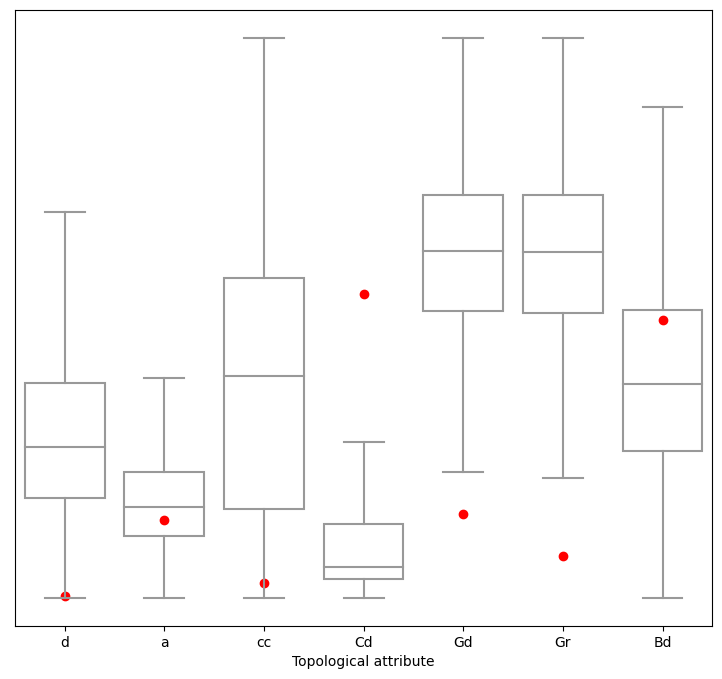

In [231]:
tempdata = list()
for col in attributes_normal.columns:
    temp = pd.DataFrame()
    temp['Value'] = attributes_normal[col].to_list()
    temp['Topological attribute'] = col
    temp['Network'] = attributes_normal.index
    temp['Benchmark model'] = 'False'
    temp.loc[temp['Network'] == 'benchmark', 'Benchmark model'] = 'True' 
    tempdata.append(temp)

tempdata = pd.concat(tempdata)

fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax = sns.boxplot(data=tempdata, x="Topological attribute", y="Value", color='white', showfliers = False)



for att in ['d', 'a', 'cc', 'Cd', 'Gd', 'Gr', 'Bd']:
    ax.scatter(att, attributes_ctown[att], alpha=1, color='red')
plt.yticks([])
plt.ylabel('')
plt.show()

In [257]:
print(attributes_normal['d'].sort_values())
print(attributes_normal['d'].sort_values().index.to_list())

Network
variant_300    0.000000
variant_62     0.010526
variant_211    0.021053
variant_167    0.031579
variant_63     0.036842
                 ...   
variant_216    0.715789
variant_121    0.742105
variant_135    0.763158
variant_181    0.831579
variant_96     1.000000
Name: d, Length: 295, dtype: float64
['variant_300', 'variant_62', 'variant_211', 'variant_167', 'variant_63', 'variant_69', 'variant_118', 'variant_21', 'variant_225', 'variant_294', 'variant_220', 'variant_198', 'variant_207', 'variant_237', 'benchmark', 'variant_9', 'variant_168', 'variant_284', 'variant_290', 'variant_60', 'variant_206', 'variant_196', 'variant_140', 'variant_302', 'variant_109', 'variant_158', 'variant_228', 'variant_107', 'variant_131', 'variant_83', 'variant_291', 'variant_226', 'variant_262', 'variant_50', 'variant_32', 'variant_189', 'variant_201', 'variant_195', 'variant_95', 'variant_244', 'variant_183', 'variant_15', 'variant_230', 'variant_304', 'variant_305', 'variant_68', 'variant_22', '